In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [8]:
# Options/Ways to segregate foreground and background
# Take the sample, perform RPCA, then use that as an additional
# Number of frames we want in one sequence to predict the error. For this dataset, has to be a 
# multiple of 20 because there are 20 frames for each video.

# Creating list of images. 
num_frames_in_sequence = 4
base_path = 'data_scene_flow_multiview/training'
num_videos = 200
num_frames = 20
data_videos = {}
video_ctr = 0
# list of lists for the videos.
for image_folder in os.listdir(base_path):
    for i in range(num_videos):
        frames = []
        for j in range(num_frames):
            if len(frames) == num_frames_in_sequence:
                data_videos[video_ctr] = frames
                video_ctr += 1
                frames = []
            v_number = "{:06d}".format(i)
            f_number = "{:02d}".format(j)
            frame_path = f'{base_path}/{image_folder}/{v_number}_{f_number}.png'
            frames.append(frame_path)
        data_videos[video_ctr] = frames
        video_ctr += 1

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_scene_flow_multiview/training'

In [ ]:
# Selecting filters (on a random basis)
base_filter_path = 'images/transparent/'
filters = []
num_crops = 10
num_tfs = 16
random.seed(42)
filter_bases = [
    'background-bullet-hole-glass-abstract-crime-gun-shot.jpg_crop',
    'black-backgrdound-with-broken-glass-texture.jpg_crop',
    'black-background-with-shasttered-glass-texture.jpg_crop',
    'black-cracked-background-dwith-broken-glass-texture.jpg_crop',
    'broken-glass-black-background-texture-backdrop-object-design-accident-crash-concept.jpg_crop',
    'abstract-broken-glass-texture-black-background-cracked-black-glass.jpg_crop',
    'broken-glass-is-insulated-against-black-background-white-cracks.jpg_crop',
    'broken-glass-screen-crack-texture.jpg_crop',
    'broken-glasss-texturse-with-hole-shape.jpg_crop',
    'cracked-glass-black-background-closesup.jpg_crop',
    'pf-s98-td-0078.jpg_crop',
    'S.jpg_crop',
    'scratch-grunge-urban-background-grunge-black-white-distress-texturegrunge-rough-dirty.jpg_crop',
    'shattered-glass-s.jpg_crop',
    'smashed-glass-dark-background-with-design-space.jpg_crop'
]

for filter_base in filter_bases:
    for i in range(num_crops):
        for j in range(num_tfs):
            filters.append(f'{base_filter_path}{filter_base}{i+1}.png_ctr{j+1}.png.png')
random.shuffle(filters)
print("Total filters",len(filters))

Total filters 2400


In [4]:
from dataset import KITTIFlowDataset
kf_dataset = KITTIFlowDataset(data = data_videos,filters = filters)
kf_dataloader = DataLoader(kf_dataset, batch_size = 1, shuffle = True)

Load Mask-RCNN to get segmentation masks

In [6]:
device ='cuda'

2.2.1+cu118


In [7]:
from segmentation import SegmentationModel
# Loading the pre-trainined version of MaskRCNN.
segmentation_model = SegmentationModel(device=device)

In [6]:
from utils import calculate_optical_flow

In [28]:
torch.cuda.empty_cache()

In [7]:
# Steps
# Step 1: Find segmentation masks for each frame
# Step 2: Calculate optical flow between each frame
# Step 3: Give optical flow information, fixed random noise to a 2D-UNet
#         for estimating clean image and obstruction. 

H = 120 # Height of downsampled image
W = 400 # Width of downsampled image
C = 3 # Number of channels
N = 4 # Number of frames

sm_confidence_threshold = 0.5
for batch_data in kf_dataloader:
    
    X,y,noise = batch_data
    batch_size = X.shape[0]
    # Generating random noise for reconstruction of the image without the error/fault
    X_clean = torch.randn(X.shape)
    # X shape - (BS,N,C,H,W)
    
    # # STEP-1: Find segmentation masks for each frame
    # # -------------------------------------------------------------------------
    # frames = X.reshape(-1,C,H,W).to(device)
    # # frames = transform(frames)
    # masks = segmentation_model.get_segmentation_masks(frames=frames)
    # of_input = masks.reshape(batch_size,N,H,W)
    # # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    
    # # STEP-2: Find optical flow values
    # # -------------------------------------------------------------------------
    # # Optical Flow of segmented frames
    # segmented_of = calculate_optical_flow(x = of_input.unsqueeze(2))
    # Optical Flow of full RGB frames
    full_of = calculate_optical_flow(x = X)
    # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

    # # STEP-3 Fuse/Concatenate all optical flow values and RGB for input to the U-Net
    # # -------------------------------------------------------------------------
    # # Concatenating all outputs along the channel dimension: New vector has 7 channels
    # X_all = torch.concatenate((segmented_of,full_of,X[:,1:,:,:,:]),dim=2)

    break

C:\Users\Manav Prabhakar\AppData\Local\Temp\ipykernel_21440\3120634117.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(batched_results).permute(0,1,4,2,3)


In [70]:
def compute_rpca(x):
    batch_size,N,C,H,W = x.shape
    for i in range(batch_size):
        img = convert_to_gray(x=x[i])
        # img -> N x H X W
        # Need to transform it to (H*W,N) 
        data = img.reshape(N,-1).T
        rpca = R_pca(data)
        L,S = rpca.fit(max_iter=10000, iter_print=10) 
    return L,S

In [72]:
from r_pca import R_pca
L,S = compute_rpca(x=X)

(4, 120, 400)


In [ ]:
# Perform optical flow of all RGB frames
# Perform optical flow of segmentation masks
# Give RGB images 
# Concatenate all of these, then pass through LSTM
# Pass LSTM O/P to 

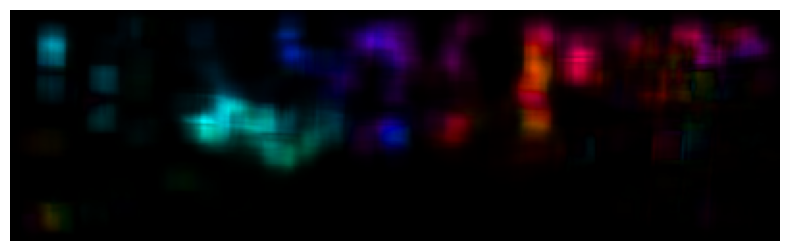

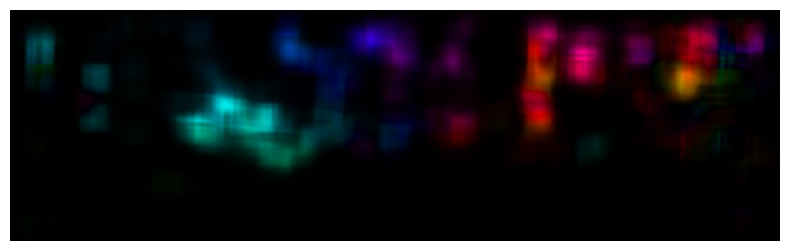

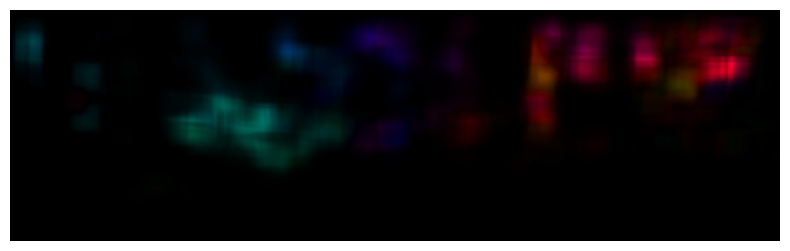

In [131]:
of_input = masks.reshape(batch_size,N,H,W)
from cv2_plt_imshow import cv2_plt_imshow
br = calculate_optical_flow(x = X,visualize=True)

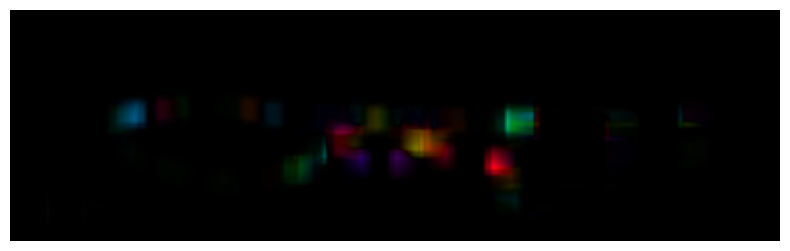

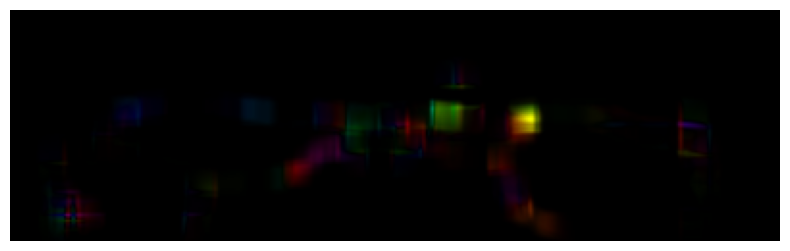

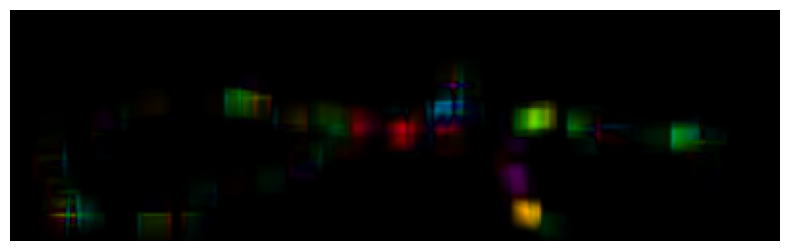

In [132]:
br = calculate_optical_flow(x = of_input.unsqueeze(2),visualize=True)

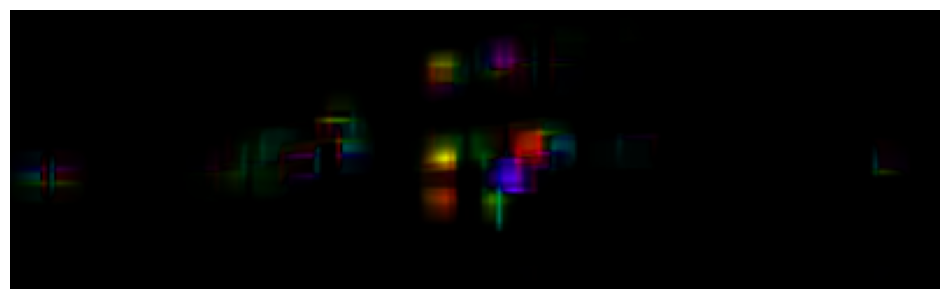

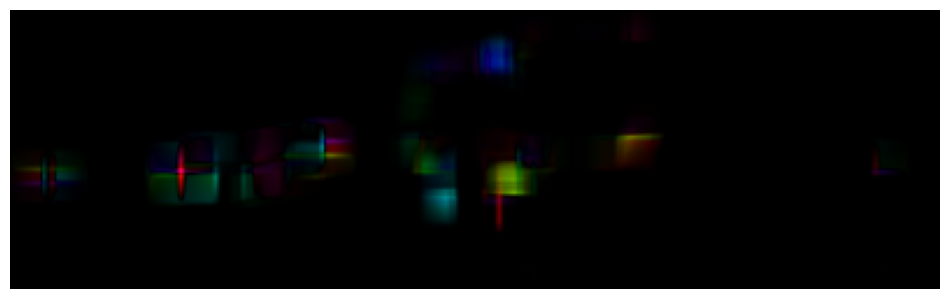

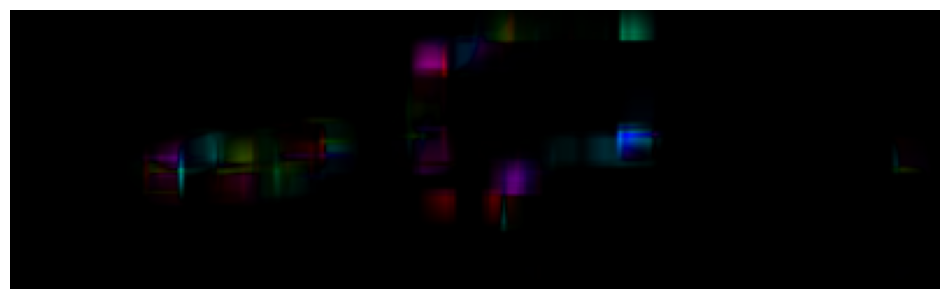

In [148]:
for m in range(3):
    # Set image hue according to the optical flow direction
    flow = cv2.calcOpticalFlowFarneback(of_input[0][m].cpu().numpy(), of_input[0][m+1].cpu().numpy(), None,
                                            pyr_scale=0.5, levels=3, winsize=15,
                                            iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    # Compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask = np.zeros((120,400,3))
    mask[..., 1] = 255
    mask[..., 0] = angle * 180 / np.pi / 2

    # Set image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)


    # Convert HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(np.uint8(mask), cv2.COLOR_HSV2BGR)
    plt.figure(figsize=(12,5))
    plt.axis('off')
    cv2_plt_imshow(rgb)
    plt.show()

In [84]:
from cv2_plt_imshow import cv2_plt_imshow
from utils import flow_viz
def viz(img, flo):
    img = img[0].cpu().detach().numpy()
    flo = flo[0].permute(1,2,0).cpu().detach().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    plt.imshow(flo)
    plt.show()
    img_flo = np.concatenate([img, flo], axis=0)

    # import matplotlib.pyplot as plt
    # plt.imshow(img_flo / 255.0)
    # plt.show()
    plt.figure(figsize=(12,5))
    cv2_plt_imshow(img_flo[:, :, [2,1,0]]/255.0)
    plt.axis('off')
    plt.show()
    return flo

In [83]:
if torch.isnan(X[0][0]).any() or torch.isinf(X[0][0]).any():
    print("NaN or Inf values detected in grayscale image before duplication")

In [79]:
flow_up[0].shape, X[0].shape

(torch.Size([2, 120, 400]), torch.Size([4, 120, 400, 3]))

In [85]:
viz(img=X[0],flo=flow_up)

e:\Manav_UMich\Documents\UMTRI\sensor-failure\RAFT/core\utils\flow_viz.py:91: RuntimeWarning: invalid value encountered in cast
  k0 = np.floor(fk).astype(np.int32)


IndexError: index -2147483648 is out of bounds for axis 0 with size 55

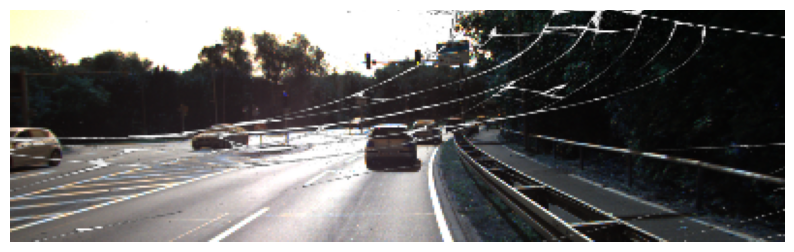

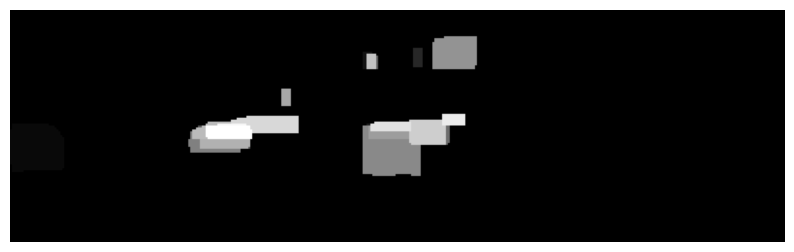

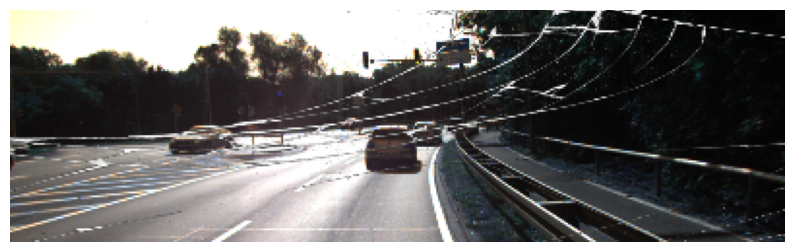

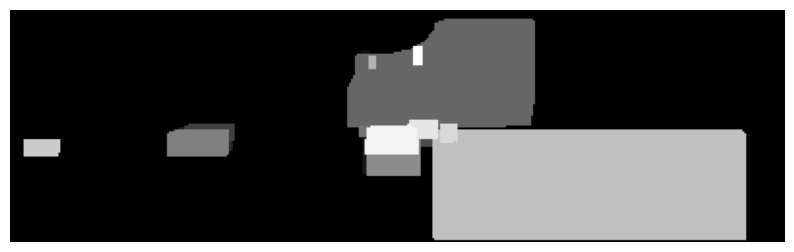

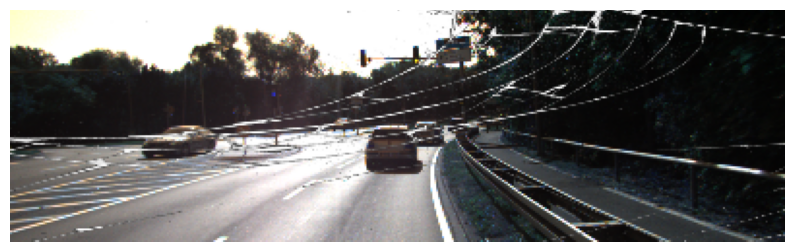

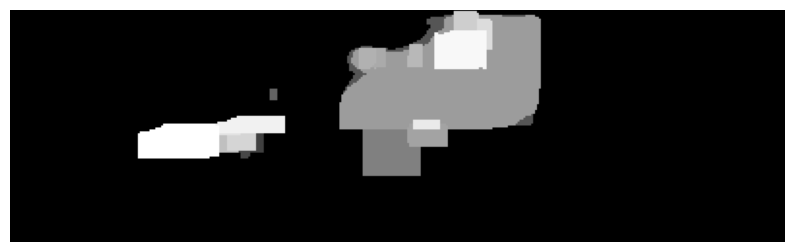

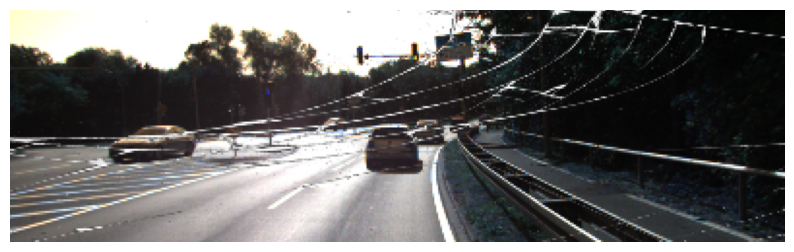

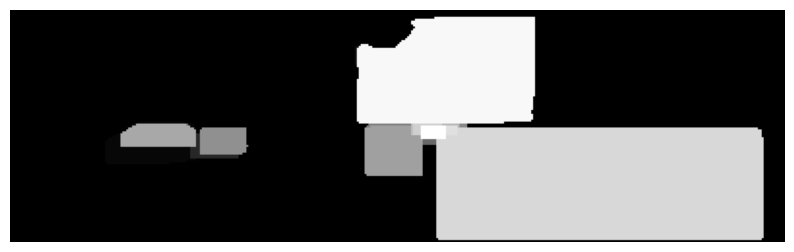

In [32]:
for j in range(4):
    plt.figure(figsize=(10,8))
    plt.imshow(X[0][j].cpu().numpy(),cmap='gray')
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(10,8))
    plt.imshow(of_input[0][j].cpu().numpy(),cmap='gray')
    plt.axis('off')
    plt.show()